# Определение стоимости автомобилей

**Цель проекта:**  
Нужно построить модель для определения стоимости автомобиля для сервиса по продаже автомобилей с пробегом для компании, которая разрабатывает приложение для привлечения новых клиентов.   
В нём можно быстро узнать рыночную стоимость своего автомобиля.  
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Заказчику важны:

- качество предсказания, измеряемое по метрике RMSE, не менее 2500;
- время предсказания;
- время обучения.

В процессе выполнения проекта планируется выполнить следующее:
- Загрузка и изучение данных
- Заполнение пропущенных значений и обработка аномалии в столбцах. 
- Удаление неинформативных признаков при их наличии.
- Подготовка выборки для обучения моделей.
- Обучение ряда моделей с подбором гиперпараметров.
- Анализ времени обучения, времени предсказания и качества моделей.
- Выбор лучшей модели, опираясь на критерии заказчика, и проверка её качества на тестовой выборке.

## Подготовка данных

### Загрузка библиотек и данных

Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Определение глобальных констант

In [3]:
RANDOM_STATE = 12345

Загрузка данных

In [4]:
try:
    df = pd.read_csv('autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')
    
#вывод параметров датасета для проверки    
display(df.shape)
display(df.info())
display(df.head())
display(df.describe())

(354369, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Исследование данных

Проверка на наличие явных дубликатов и их удаление. 

In [5]:
# Проверка на явные дубликаты
print('Количество явных дубликатов', df.duplicated().sum())

# Удаление явных дубликатов
df.drop_duplicates(inplace=True)

# сброс индексов
df=df.reset_index(drop=True)

# Проверка результата
print('Количество явных дубликатов после удаления', df.duplicated().sum())
old_df_shape = df.shape[0]
display(old_df_shape)
display(df.info())
display(df.describe())

Количество явных дубликатов 4
Количество явных дубликатов после удаления 0


354365

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Проверка признаков на корреляцию

In [6]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
Kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
RegistrationMonth,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


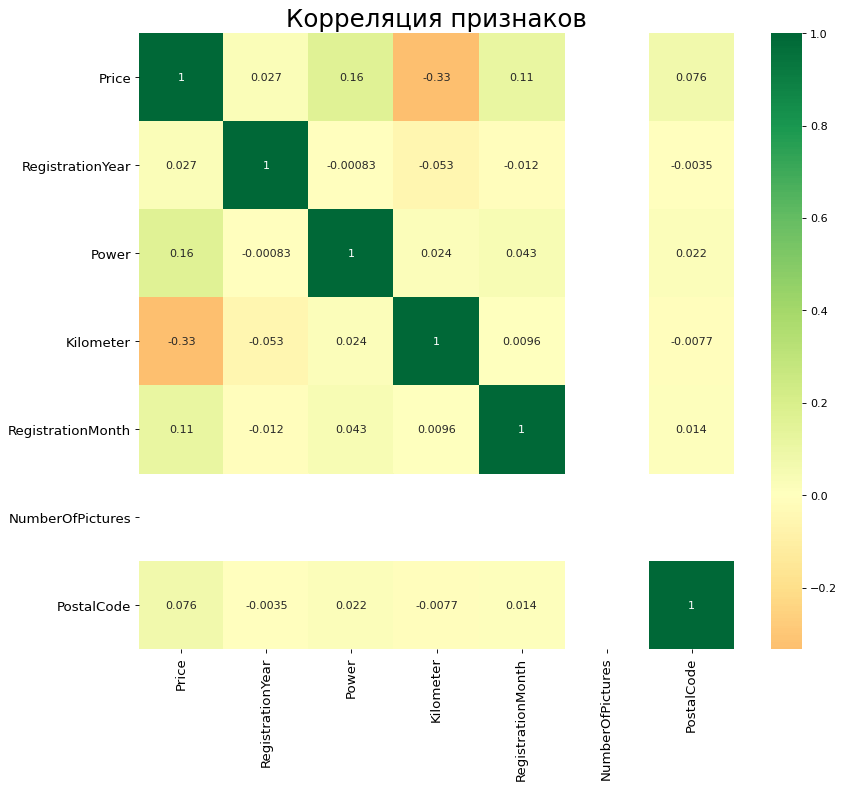

In [7]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Вывод**  
1. Явной корреляции признаков не наблюдается, значит мультиколлинеарность не будет мешать обучению моделей.  
2. Есть ряд признаков, которые не являются значимыми и их надо удалить, а именно:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
3. В числовых признаках 'Price','RegistrationYear' и 'Power' есть выбросы. которые надо проанализировать и удалить
4. Пропуски есть только в категориальных признаках и мы их заменим на параметр 'Unknown', который модели нормально принимают.

### Предобработка данных

#### Удаление незначимых признаков

In [8]:
df = df.drop(['DateCrawled','RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
display(df.shape)
display(df.info())
display(df.head())
display(df.describe())

(354365, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


,Price,RegistrationYear,Power,Kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


#### Удаление выбросов

Определим функции для построения графиков

In [9]:
#функция для построения гистограмм
def plot_histogram(feature,hist_title,x_label):
    plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':100})
    plt.hist(feature, alpha=0.8, bins=200)    
    plt.title(hist_title)
    plt.ylabel('Количество повторений в датасете')
    plt.xlabel(x_label)
    plt.show()

In [10]:
#функция для построения ящиков с усами
def plot_boxplot(feature,hist_title,x_label):
    plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':100})
    plt.boxplot(feature, vert=0)    
    plt.title(hist_title)
    plt.xlabel(x_label)
    plt.show()

Анализ и удаление выбросов в признаке 'Price'

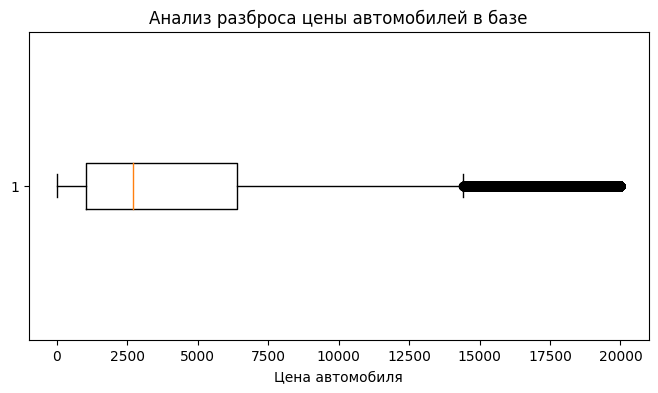

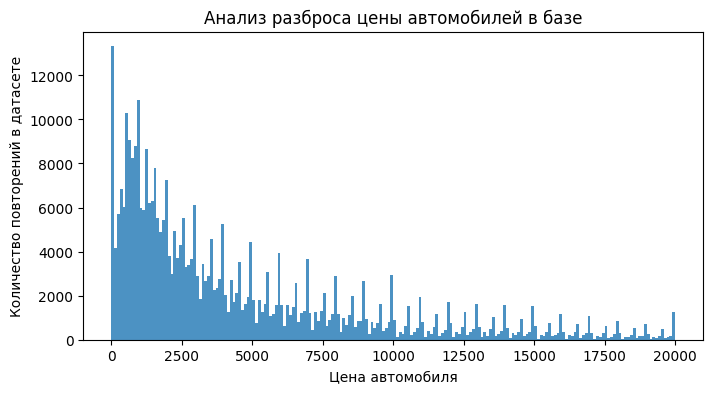

In [11]:
car_price = df['Price']
plot_boxplot(car_price,'Анализ разброса цены автомобилей в базе','Цена автомобиля')
plot_histogram(car_price,'Анализ разброса цены автомобилей в базе','Цена автомобиля')

**Вывод**  
На гистограмме виден выброс в районе нулевой отметки. Эти данные можно отбросить.

Удаление строк с околонулевой ценой.

In [12]:
# устанавливаем порог околонулевого значения, чтобы отсечь выбросы
threshold = 10

#убираем строки с околонулевыми значениями
df = df[df['Price'] > threshold]

#сбрасываем индексы
df = df.reset_index(drop=True)
                   
#print(df_train.shape)
#print(df_train.info())

In [13]:
# устанавливаем порог околонулевого значения 100 для цены , чтобы отсечь выбросы
threshold = 100

#убираем строки с околонулевыми значениями
df = df[df['Price'] > threshold]

#сбрасываем индексы
df = df.reset_index(drop=True)
                   
#print(df_train.shape)
#print(df_train.info())

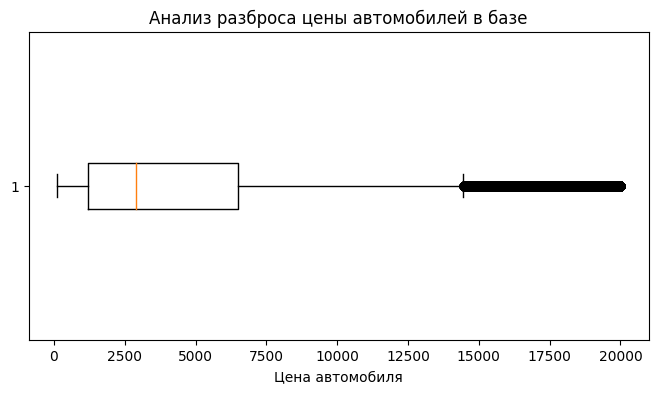

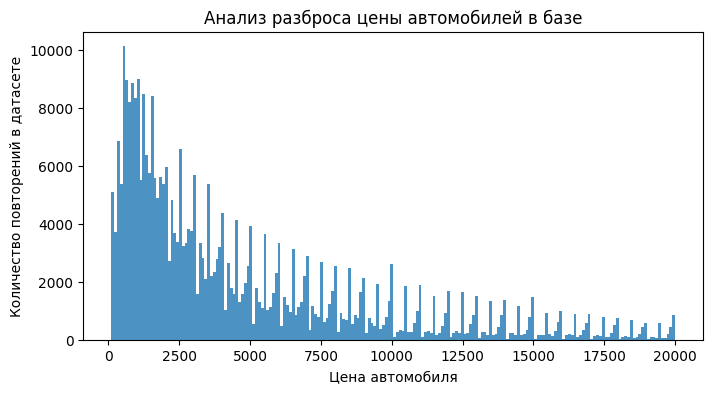

In [14]:
#проверяем результат графическим образом 
car_price = df['Price']
plot_boxplot(car_price,'Анализ разброса цены автомобилей в базе','Цена автомобиля')
plot_histogram(car_price,'Анализ разброса цены автомобилей в базе','Цена автомобиля')

**Вывод**  
Выброса в районе нулевой отметки теперь нет, с данными можно дальше работать.

Анализ и удаление выбросов в признаке 'RegistrationYear'

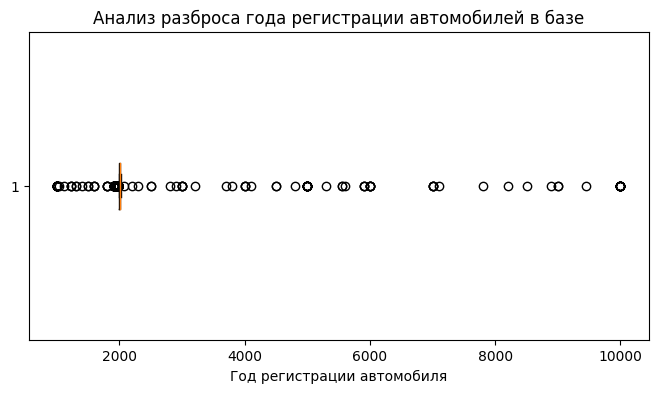

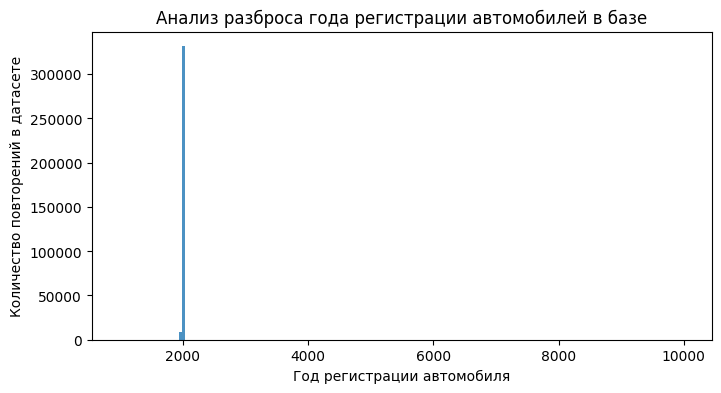

In [15]:
car_year = df['RegistrationYear']
plot_boxplot(car_year,'Анализ разброса года регистрации автомобилей в базе','Год регистрации автомобиля')
plot_histogram(car_year,'Анализ разброса года регистрации автомобилей в базе','Год регистрации автомобиля')

**Вывод**  
В датасете есть элементы с годом регистрации как больше текущего так и сильно меньше (допустим, до 1985 года). Такие данные вероятно были введены ошибочно, или в результате сбоя системы. Их можно отбросить. 

Удаление строк с годом регистрации больше текущего.

In [16]:
# устанавливаем порог верхнего значения, чтобы отсечь выбросы
upper_threshold = 2023
lower_threshold = 1985

#убираем строки с околонулевыми значениями
df = df[(df['RegistrationYear'] < upper_threshold) &
        (df['RegistrationYear'] > lower_threshold)]

#сбрасываем индексы
df = df.reset_index(drop=True)
                   

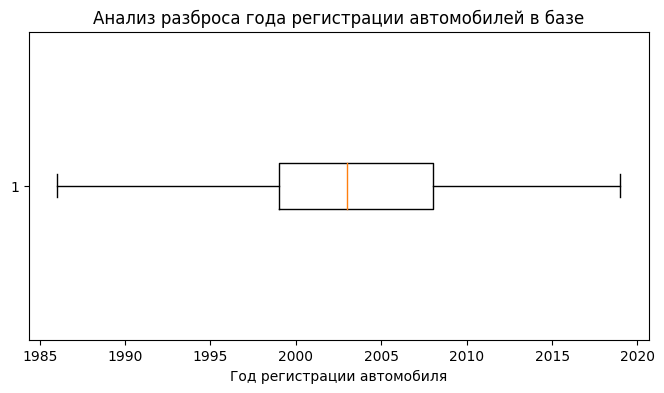

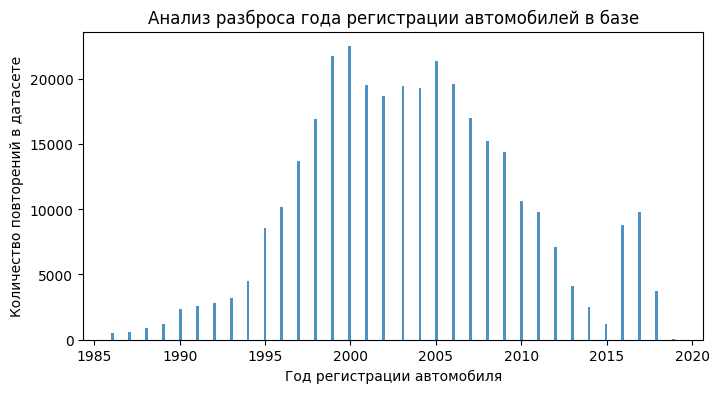

In [17]:
car_year = df['RegistrationYear']
plot_boxplot(car_year,'Анализ разброса года регистрации автомобилей в базе','Год регистрации автомобиля')
plot_histogram(car_year,'Анализ разброса года регистрации автомобилей в базе','Год регистрации автомобиля')

**Вывод:**  
В признаке RegistrationYear явных выбросов больше не наблюдаем, можно дальше работать с данными.

Анализ и удаление выбросов в признаке 'Power'

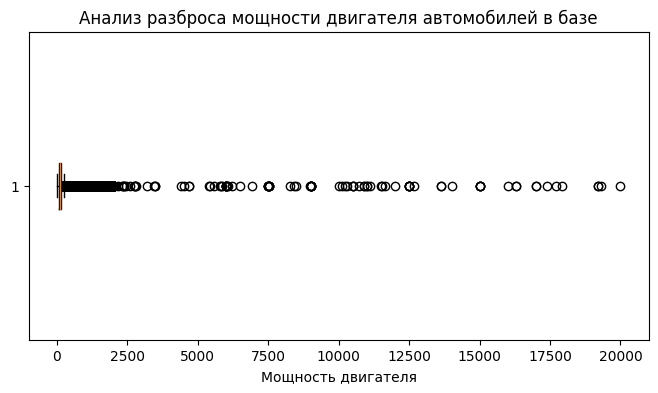

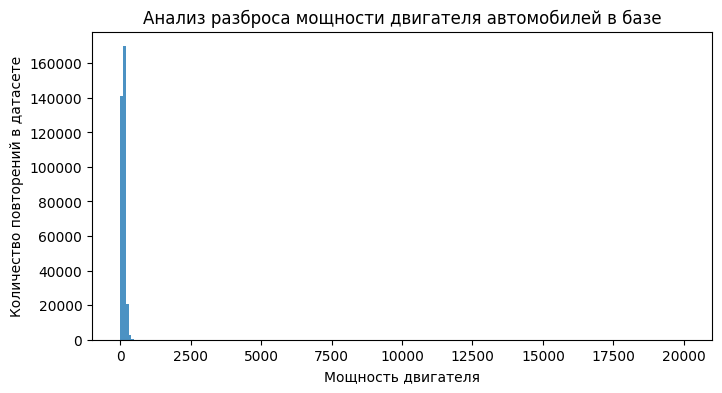

In [18]:
car_power = df['Power']
plot_boxplot(car_power,'Анализ разброса мощности двигателя автомобилей в базе','Мощность двигателя')
plot_histogram(car_power,'Анализ разброса мощности двигателя автомобилей в базе','Мощность двигателя')

**Вывод**  
В датасете есть элементы с большим разбросом мощности от практически нулевого до немыслимых значений. Такие данные вероятно были введены ошибочно, или в результате сбоя системы. Предполагаем, что ошибкой будет мощность меньше 30 и больше 500 и такие данные  можно отбросить. 

In [19]:
# устанавливаем порог верхнего значения, чтобы отсечь выбросы
upper_threshold = 500
lower_threshold = 30

#убираем строки с околонулевыми значениями
df = df[(df['Power'] < upper_threshold) &
        (df['Power'] > lower_threshold)]

#сбрасываем индексы
df = df.reset_index(drop=True)
                   
#print(df_train.shape)
#print(df_train.info())

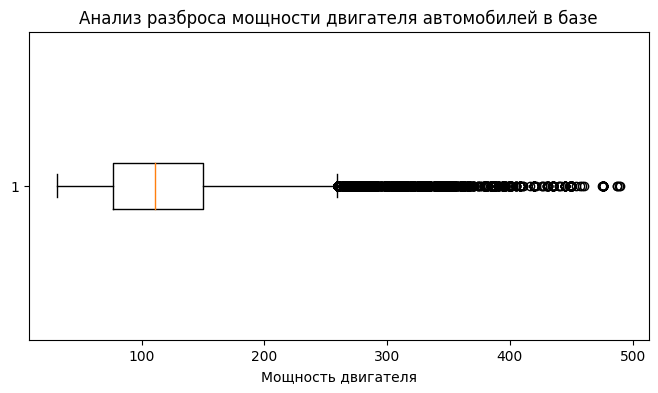

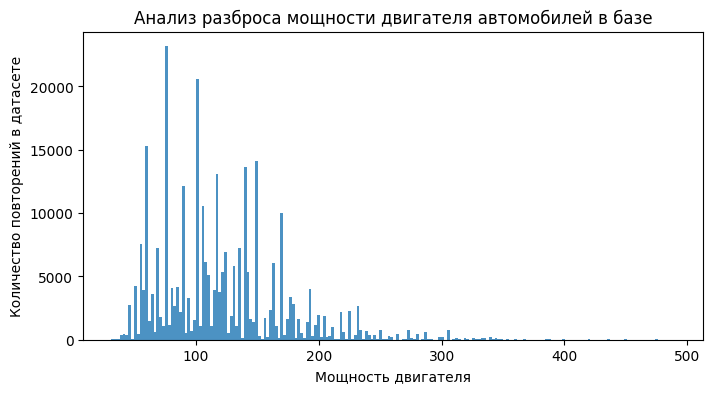

In [20]:
car_power = df['Power']
plot_boxplot(car_power,'Анализ разброса мощности двигателя автомобилей в базе','Мощность двигателя')
plot_histogram(car_power,'Анализ разброса мощности двигателя автомобилей в базе','Мощность двигателя')

**Вывод:**
В признаке 'Power' явных выбросов больше не наблюдаем, можно дальше работать с данными.

Проверяем долю удаленных данных 

In [21]:
new_df_shape = df.shape[0]
print('Доля удаленных строк:',(old_df_shape-new_df_shape) / old_df_shape)


Доля удаленных строк: 0.15266180350768277


**Вывод:**
    Доля удаленных строк превышает 10%, но все же меньше 20%, и данные значительно более надежны для обучения моделей. Порскольку у нас нет достоверного способа исправления таких выбросов, дальше работаем с очищенным датасетом. 

#### Заполнение пропусков в категориальных признаках данных

In [22]:
# проверяем изначальное количество пропусков
display(df.isna().sum())

Price                   0
VehicleType         20640
RegistrationYear        0
Gearbox              5707
Power                   0
Model               11368
Kilometer               0
FuelType            18953
Brand                   0
Repaired            45360
dtype: int64

In [23]:
# удаляем пропуски
df.loc[(df['VehicleType'].isna()), 'VehicleType'] = 'Unknown'
df.loc[(df['Gearbox'].isna()), 'Gearbox'] = 'Unknown'
df.loc[(df['Model'].isna()), 'Model'] = 'Unknown'
df.loc[(df['FuelType'].isna()), 'FuelType'] = 'Unknown'
df.loc[(df['Repaired'].isna()), 'Repaired'] = 'Unknown'

#контроль результата
display(df.isna().sum())

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

#### Разделение данных на обучающую и тестовую выборки 

In [24]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=RANDOM_STATE)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(225200, 9)
(75067, 9)
(225200,)
(75067,)


In [25]:
# формируем список столбцов для масштабирования
numeric = ['RegistrationYear','Power','Kilometer']

scaler = StandardScaler() # создание объекта
scaler.fit(features_train[numeric]) # настройка на обучающих данных 
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

display(features_train.head()) # контроль результата
display(features_test.head()) # контроль результата


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
232462,bus,1.350370,manual,-0.654636,caddy,-0.795846,petrol,volkswagen,no
138373,coupe,0.861544,auto,1.313265,a5,-0.106256,gasoline,audi,no
140534,wagon,-0.116109,manual,1.029433,156,0.583333,gasoline,alfa_romeo,no
160423,small,-0.604936,manual,-1.430442,fortwo,0.583333,petrol,smart,no
35577,sedan,-0.930820,manual,-0.862779,astra,0.583333,petrol,opel,no


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
106067,convertible,1.024486,manual,-0.295115,beetle,-1.899189,gasoline,volkswagen,no
221260,sedan,-0.116109,manual,0.291470,6_reihe,-0.106256,gasoline,mazda,no
131613,small,-0.767878,Unknown,-1.146611,corsa,-0.106256,petrol,opel,no
98082,bus,0.372717,manual,0.934822,touran,-0.106256,gasoline,volkswagen,no
188166,wagon,0.209775,manual,0.556380,astra,0.583333,gasoline,opel,no


#### Кодирование категориальных признаков тренировочной выборки

In [26]:
# определяем список категориальных признаков
categorical = ['VehicleType', 'Gearbox', 'Model', 
       'FuelType', 'Brand', 'Repaired']

# определяем энкодер
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[categorical])

# добавляем закодированные признаки в тренировочную выборку
features_train[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_train[categorical])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(categorical, axis=1)

# смотрим на результат
features_train.head()

,RegistrationYear,Power,Kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_smart,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_yes
232462,1.350370,-0.654636,-0.795846,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
138373,0.861544,1.313265,-0.106256,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
140534,-0.116109,1.029433,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
160423,-0.604936,-1.430442,0.583333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35577,-0.930820,-0.862779,0.583333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Кодирование категориальных признаков тестовой выборки

In [27]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(features_test[categorical])

features_test = features_test.drop(categorical, axis=1)

# смотрим на результат
features_test.head()

,RegistrationYear,Power,Kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,...,x4_smart,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_yes
106067,1.024486,-0.295115,-1.899189,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
221260,-0.116109,0.291470,-0.106256,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
131613,-0.767878,-1.146611,-0.106256,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
98082,0.372717,0.934822,-0.106256,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
188166,0.209775,0.556380,0.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [28]:
# на всякий случай проверяем количество признаков в обеих выборках
features_train.shape, features_test.shape

((225200, 309), (75067, 309))

**Вывод:** количество признаков в обеих выборках совпадает

In [29]:
# Проверяем, есть ли несовпадающие признаки в тренировочной и тестовой выборках
(features_train.columns != features_test.columns).sum()

0

**Вывод:** признаки в обеих выборках совпадает

**Вывод по разделу исследования и подготовки данных:**  

В процессе подготовки данных было выполнено следующее:
- Загрузка и изучение данных
- Заполнение пропущенных значений и обработка аномалии в столбцах.
- Прверка признаков на корреляцию
- Удаление обнаруженных неинформативных признаков.
- Разбиение выборки на тренировочную и тестовую для обучения моделей.
- Масштабирование числовых признаков и кодирование категориальных в обеих выборках.

В результате, данные полностью готовы для обучения моделей

## Обучение моделей

Будем оценивать качество обучения на тренировочной выборке с применением кросс-валидации для следующих моделей:
- модели Линейной регресссии
- модели Случайного леса
- модели градиентного бустинга LightGBM
- модели градиентного бустинга CatBoost¶

### Обучение модели Линейной регресссии

In [30]:
%%time
# используем модель линейной регрессии. 
lr_model = LinearRegression()
rmse_LR = (cross_val_score(lr_model, 
                           features_train, 
                           target_train, 
                           cv=3, 
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средняя метрика  RMSE качества модели линейной регресии', rmse_LR)

Средняя метрика  RMSE качества модели линейной регресии 2346.521227329439
CPU times: total: 27.3 s
Wall time: 9.4 s


**Вывод:**  
Метрика RMSE для модели линейной регрессии на тренировчной выборке составила 2340, что удовлетворяет требованиям заказчика.  Время обучения модели на тренировочной выборке: 9.43 s. 

### Обучение модели Случайного леса

In [31]:
%%time

forest = RandomForestRegressor(random_state=RANDOM_STATE)

# определение списка и диапазона гиперпараметров для подбора
grid_space={'max_depth': range (6, 16, 5),
            'n_estimators': range (120,220,50)}

# подбор параметров с кросс-валидацией
forest_grid = GridSearchCV(forest, param_grid=grid_space, 
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

model_grid = forest_grid.fit(features_train,target_train)

final_score_forest = abs(model_grid.best_score_)**0.5

print('Гиперпараметры лучшей модели: '+str(model_grid.best_params_))
print('Метрика RMSE лучшей модели: '+str(final_score_forest))



Гиперпараметры лучшей модели: {'max_depth': 11, 'n_estimators': 170}
Метрика RMSE лучшей модели: 1779.588918496691
CPU times: total: 9min 8s
Wall time: 17min 17s


**Вывод:**  
Метрика RMSE модели случайного леса на тренировочной выборке составила 1780, что удовлетворяет требованиям заказчика и лучше, чем у модели линейной регрессии.   
Время обучения модели с подбором гиперпараметров на тренировочной выборке: 17min 33s   
Оптимальные гиперпараметры модели:
- max_depth = 11
- n_estimators = 170

### Обучение модели градиентного бустинга  LightGBM

In [32]:
%%time

model_lgbm = LGBMRegressor() 

# определение списка и диапазона гиперпараметров для подбора
grid_space = [{'num_leaves':range (400, 600, 100),
               'n_estimators': range (100,500,200), 
               'random_state':[RANDOM_STATE]}]

# подбор параметров с кросс-валидацией
lgbm_boost_grid = GridSearchCV(model_lgbm, param_grid=grid_space, 
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

model_grid_lgbm = lgbm_boost_grid.fit(features_train,target_train)

final_score_lgbm = abs(model_grid_lgbm.best_score_)**0.5

print('Гиперпараметры лучшей модели: '+str(model_grid_lgbm.best_params_))
print('Метрика RMSE лучшей модели: '+str(final_score_lgbm))


Гиперпараметры лучшей модели: {'n_estimators': 300, 'num_leaves': 400, 'random_state': 12345}
Метрика RMSE лучшей модели: 1483.3552391294752
CPU times: total: 3min 7s
Wall time: 34.7 s


**Вывод:**  
Метрика RMSE модели градиентного бустинга LightGBM на тренировочной выборке составила 1483, что удовлетворяет требованиям заказчика и лучше, чем у модели Линейной регрессии и у модели Случайного леса.   
Время обучения модели с подбором гиперпараметров на тренировочной выборке: 33.4 s  
Оптимальные гиперпараметры модели:
- num_leaves = 400
- n_estimators = 300

### Обучение модели градиентного бустинга CatBoost

In [33]:
%%time

model_cat = CatBoostRegressor(verbose=False)

# определение списка и диапазона гиперпараметров для подбора
grid_space={'iterations': range (900, 1000, 50),
            'depth': range (12,16,2),
            'random_state':[RANDOM_STATE]}

# подбор параметров с кросс-валидацией
cat_boost_grid = GridSearchCV(model_cat, param_grid=grid_space, 
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

model_grid_cat = cat_boost_grid.fit(features_train,target_train)

final_score_forest = abs(model_grid_cat.best_score_)**0.5

print('Гиперпараметры лучшей модели: '+str(model_grid_cat.best_params_))
print('Метрика RMSE лучшей модели: '+str(final_score_forest))


Гиперпараметры лучшей модели: {'depth': 14, 'iterations': 950, 'random_state': 12345}
Метрика RMSE лучшей модели: 1480.6915866436302
CPU times: total: 8min 33s
Wall time: 14min 18s


**Вывод:**  
Метрика RMSE модели градиентного бустинга CatBoost на тренировочной выборке составила 1481, что удовлетворяет требованиям заказчика и лучше, чем у всех остальных моделей.   
Время обучения модели с подбором гиперпараметров на тренировочной выборке: 14min 34s   
Оптимальные гиперпараметры модели:
- iterations = 950
- depth = 14

## Анализ моделей

**На основании обучения моделей на тренировочной выборке с подбором гиперпараметров мы видим следующее:**
- Все использованные модели показали качество работы по метрике RMSE ниже 2500, что удовлетворяет требования заказчика
- Наименьшее время обучения и предсказания при наихудшем качестве (RMSE = 2340) показала модель Линейной регрессиии
- Модель Случайного леса показала результат RMSE = 1780, что лучше, чем у Линейной регрессии, но хуже, чем у моделей градиентного бустинга.
- Модель градиентного бустинга LightGBM показала результат RMSE = 1483, что лучше, чем у Линейной регрессии и Случайного леса, при высокой скорости обучения. 
- Наилучшее качество по метрике RMSE = 1481 показала модель градиентного бустинга СatBoost, следовательно она признана лучшей и мы отбираем ее для проверки на тестовой выборке.

Определим функцию для проверки качества и времени предсказания моделей на тестовой выборке

In [34]:
# получение предсказания модели на тестовой выборке
def test_predict(model, features_test, target_test):
    predictions_test = model.predict(features_test) 
    
    #выравнивание индексов
    predictions_test = pd.Series(predictions_test, target_test.index)

    # расчет метрики RMSE на тестовой выборке
    rmse = mean_squared_error(target_test, predictions_test)**0.5 
    return rmse


### Проверка лучшей модели градиентного бустинга CatBoost на тестовой выборке

Измерение времени обучения модели

In [35]:
%%time
model_cb = CatBoostRegressor(iterations=950,
                             depth=14, 
                             verbose=False)
# Fit model
model_cb.fit(features_train,target_train)


CPU times: total: 8min 58s
Wall time: 6min 5s


Измерение качества и времени предсказания модели на тестовой выборке.

In [36]:
%%time
cat_boost_rmse = test_predict(model_cb, features_test, target_test)
print('Метрика RMSE на тестовой выборке для модели градиентного бустинга CatBoost:', cat_boost_rmse)

Метрика RMSE на тестовой выборке для модели градиентного бустинга CatBoost: 1455.7242776640708
CPU times: total: 2.88 s
Wall time: 222 ms


**Вывод:**    
Параметры модели градиентного бустинга CatBoost при проверке на тестовой выборке:
- Метрика RMSE: 1456
- Время обучения модели: 5min 43s 
- Время предсказания модели: 211 ms

### Проверка моделей на адекватность

Сравним качество предсказания моделей с результатами DummyRegressor

In [37]:
%%time
dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(features_train,target_train) # обучение модели на тренировочной выборке
dummy_rmse = test_predict(dummy_reg, features_test, target_test)
print('Метрика RMSE на тестовой выборке для модели Dummy:', dummy_rmse)

Метрика RMSE на тестовой выборке для модели Dummy: 4883.590096985658
CPU times: total: 15.6 ms
Wall time: 6.54 ms


**Вывод:**    
Модель Dummy показала результат RMSE = 4884  
Это значительно выше, чем результат нашей лучшей модели.  
Следовательно выбранная нами модель более, чем адекватна.

## Общий вывод

**В процессе выполнения проекта было выполнено следующее:**  
- Подготовка данных:
    - Загрузка и изучение данных
    - Заполнение пропущенных значений и обработка аномалии в столбцах.
    - Прверка признаков на корреляцию
    - Удаление обнаруженных неинформативных признаков.
    - Разбиение выборки на тренировочную и тестовую для обучения моделей.
    - Масштабирование числовых признаков и кодирование категориальных в обеих выборках.
- Oбучение на тренировочной выборке с применением кросс-валидации следующих моделей:
    - модели Линейной регресссии
    - модели Случайного леса
    - модели градиентного бустинга LightGBM
    - модели градиентного бустинга CatBoost
- Анализ характеристик этих моделей:
    - Время обучения модели с оптимально подобранными гиперпараметрами на тестовой выборке
    - Время предсказания модели на тестовой выборке
    - Оценка качества предсказания на тестовой выборке мо метрике RMSE
    - Проверка моделей на адекватность
    
**Вывод по проделанной работе:**
- Все использованные модели показали качество работы по метрике RMSE ниже 2500, что удовлетворяет требования заказчика
- Наименьшее время обучения и предсказания при наихудшем качестве (RMSE = 2340) показала модель Линейной регрессиии
- Модель Случайного леса показала результат RMSE = 1780, что лучше, чем у Линейной регрессии, но хуже, чем у моделей градиентного бустинга.
- Модель градиентного бустинга LightGBM показала результат RMSE = 1483, что лучше, чем у Линейной регрессии и Случайного леса, при высокой скорости обучения.
- Наилучшее качество по метрике RMSE = 1481 показала модель градиентного бустинга СatBoost, следовательно она и признана лучшей.
- Модель градиентного бустинга СatBoost проверена на тестовой выборке и показала следующие результаты:
    - RMSE = 1456, что лучше, чем при обучениии на тренировочной выборке.
    - Время обучения на тренировочной выборке модели с подобранными гиперпараметрами: 5min 43s
    - Время предсказания модели на тестовой выборке: 211 ms
- Модель градиентного бустинга СatBoost прошла проверку на адекватность, показав результат по RMSE значительно лучше, чем DummyRegressor
 

**Рекомендация сотрудникам компании по продаже автомобилей с пробегом:**  
- В разрабатываемом компанией приложении для привлечения новых клиентов предлагается использовать разработанную в данном проекте модель предсказания цен автомобилей на основе градиентного бустинга СatBoost.  
- Данная модель показала наилучшие результаты по совокупности требуемых характеристик качества и времени предсказания и времени обучения.